# Sound Classification Training Interface

### Introductory Note
This notebook acts as an interface to train a sound classification algorithm.
For anyone familiar with the training of neural networks it will be straigth-forward to use.
To anyone who is completely new to the topic we provide some background information.
This way the notebook will hopefully become accessible to anyone who has never touched code before.

Below we import additional code from open source libraries and from this repository.

In [2]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imp
# code from this repository
import train
import predict
from utils import preprocessing as pre
import params as p
imp.reload(p)
imp.reload(predict)
imp.reload(pre)
imp.reload(train)

<module 'train' from '/Users/lucasmoeller/Documents/BirdsOnMars/GitHub/birdsonearth/birdsonearth/train.py'>

## Parameters for training

In the following cell a parameters object is initialized, which collects all relevant parameters:
Have a look at `params.py` for a full list of parameters.

- the data under `params.data_root` must be structured as follows:
  There needs to be one subdirectory for each class containing .wav files or .mp3 files that are going to be used   for the training.
- if the directory under `params.mel_spec_root` exists it is assumed that spectograms have already been computed   and can be used for training. If not spectrograms are computed in the next step and will be saved to this    directory.
- `params.val_split` is the fraction of the data that is used to claculate test accuracy of the model
- to save the model after training set `params.save_model` to `True` and define a `params.name`
- `params.device` specifies the computing device. If you have an nvidia GPU availabel set it to `'cuda:<device index>'` otherwise to `'cpu'`
- `params.epochs` specifies the number of training iterations through the entire dataset
- to restrict the number spectrograms used for training set `params.n_max` to some integer, to use all set it to `None`

### Background
The neural network that is going to be trained with the given data is of the type VGGish and was designed for sound classification. The architecture is derived from the popular VGG net, which was however designed for image classsification. The fact that only a few small changes had to be made to the VGG net to use it for sound rather than image classification is a nice example for the general applicability of artificial neural networks to all kinds of data. This works because the data we want the net to learn to distinguish can be abstracted. Although, in the first place a sound seems to be something entirely different compared to an image it turns out both can be seen as a matrix, a collection of numbers. And unlike humans, matrices are how neural networks see the world.
How sounds can be turned into matrices is shown further below.
The parameters defined in the cell below provide some important corner stones for the training of a neural network and it is important to understand what they mean.
The training for a net is organized in epochs which are nothing but training repetitions. Just like a bodybuilder repeats a similar training routine day after day a neural network follows a similar training many times to get better. `params.n_epochs` are the number of training sessions on the plan for our network.
Now a bodybuilder may not need to do much of a reflection after training but in many other learning tasks reflection is crucial. Take for instance a little child learning to walk. After falling it will realize it did something wrong and do it differently the next time. A neural net reflects after trying its best on a 'batch of data' whose size is given by `params.batch_size`. In other words it tries to make the right prediction for say 100 sounds (or images). Then it checks what was right and what wasn't to try and do better the next time.
Anyone who really learned to master a task has gone beyond learning something by heart. You cannot become a champion of chess by repeating the same game over and over again. You want to be able to generalize your knowledge to games that you have never seen before. In order to check in how far our neural network can generalize to unheard sounds we keep aside some of them to test it on them. `params.val_split` is the fraciton of the data we don't show the net upon training.
The last aspect to mention here is the training device. This is a bit technical. For reasons of the unterlying math going on in a neural network a certain types of chips has proven to be much better than others. Namely, graphics chips (GPUs) can do these kinds of operations a lot faster than classical computing chips (CPUs).
If you have the chance coparing the two will be very impressive. 

In [3]:
params = p.Params()

params.name = 'largeBirds2_nb'

# training
params.data_format = 'wav'
params.data_root = '../data/largeBirds2'
params.mel_spec_root = '../data/largeBirds2_processed'
params.n_epochs = 50
params.batch_size = 256
params.device = 'cuda:0'
params.val_split = .2
params.save_model = True
params.n_max = 1000

## Preprocessing

The VGGish architecture that we are about to train works on spectrograms that will be computed in the next step.
To do this the data in `params.data_root` need to be wav files with a sample rate of 22050 Hz. If this is not the case they need to be resampled first. To to this use the function `preprocessing.preprocess()`.

### Background
As mentioned earlier a neural network sees the world in matrices. Therefore, we need to turn these sounds into matrices and here is how it's done. A sound consists of many frequencies. If the sound changes over time, the influence of these frequencies changes. Using a method called Fourier-Transformation a sound can be separated into frequencies and how important they are perfectly (nothing to learn here!).
In the matrix our network is given we then put frequencies on one side and time on the other. This way from each number in the resulting matrix we can see three things: A frequency at a certain time from the position and how import this frequency is at the given time by the value of the number. This is called a spectrogram.
For humans to get a grasp of the content in a matrix a good way is to make an image of it.
Each pixel in the image represents a number in the matrix. The brighter the pixel the higher the value and thus the impartance of that frequency at the given time. An example is shown below.

Throughout the training we actually don't show full sound files to the network. We cut them into pieces of fixed size (defined in `params.py`). In fact this is necessary because due to the structure of their structure many neural networks can only take fixed size inputs that need to have been processed in the exact same way! (not so intelligent in the end...)

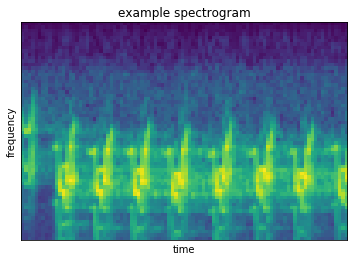

In [7]:
# just some plotting
spec = np.load('example_spec.npy')
plt.imshow(spec.T)
plt.xticks([])
plt.yticks([])
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('example spectrogram')
plt.show()

In [39]:
pre.summary(params)

the following classes and numer of instances are found:

      labels  instances
0      Parus        500
1   Picoides        173
2       Pica        248
3     Passer        501
4    Columba        171
5     Turdus        500
6    Coloeus        127
7   Garrulus        254
8  Erithacus        500
9    Sturnus        274
spectrograms for the data seem to have been computed under ../data/largeBirds2_processed                 and will be used for training


In [40]:
pre.process_wavs_for_training(params)

spectrograms seem to have been computed
delete ../data/largeBirds2_processed manually and rerun preprocessing or keep goint to use what is there.


# Training

Using the spectrograms in `params.mel_spec_root` we can now train the network

### Background
The training is done as was described earlier. To get an idea of how well our model learns over the course of the training epochs two measures are used.
Training accuracy states how well the model does in classifying the data it is shown over and over again and that it lears from by reflecting its performance.
Test accuracy measures how well the model does on sounds it has never heard (that is seen) before. For the latter we don't tell the model what the right solution was, such that it cannot learn from this data.
If the training accuracy becomes much higher than test accuracy this is a sign for the model to learn stuff by heart and that it cannot generalize well. One then speaks of overfitting. Ideally, we want both accuracies to be roughly the same but realistically this is almost never the case.
In a funny way neural nets are similar to humans in this aspect. We overfit all the time.

In [8]:
model, labels = train.start_training_with(params)

FileNotFoundError: [Errno 2] No such file or directory: '../data/largeBirds2_processed'

## Inference

To let the network predict a few files put them into the list below and run the `predict` script.
Files to be predicted are preprocessed, that is resampled and cut into pieces. From each piece a spectrogram is computed, which are then fed through the network.
To get the prediction for an entire file the predictions of its pieces are averaged over.

### Background
As for the training we don't give the entire sound file to the network because we can't! The net is limited to a fixed size input. A prediction for the entire file is obtained by averaging over the individual predictions for each piece.
This leads to a problem: neural networks have lead to increadible innovation in the field of pattern recognition over the past years. They are much better at recognizing patterns in all kinds of data than anything that has existed before. However, they cannot tell how certain they are about a prediction.
If you as a human listen to a recording of a dog bark, and for the first second or two nothing happens you will be able to tell with a high certainty that nothing interesting happened in this time which could influence your decision about what is heard in the recording.

In [42]:
files = ['../data/predictBirds/Columba.wav', '../data/predictBirds/Parus.wav']

In [43]:
predictions = predict.predict(model, labels, files, params)

starting inference
file 0 sound like a Columba to me
file 1 sound like a Parus to me
